# 2018-10-15 Retina : Spikes
Maintenant que j'ai des jolis filtres il s'agit de les faire marcher en jolis spikes.
### NB : On perd la temporalité donc c'est peut etre plus pertinent d'utiliser la variation du filtre comme un courant d'input directement dans V1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def find_middle(a_list):
    middle = len(a_list)/2
    return a_list[int(middle)]

# Filtres spatial, temporel et spatiotemporel

In [2]:
#Un premier filtre, spatial avec center-surround (voir et citer MARR ?)
def spatial_filter(wx = 5., wy = 5., xres = .1, yres = .1, sigma_center = 1., sigma_surround= 1.2,
                  x_trans = 0, y_trans = 0, theta = 0, end_multiplier = -.01) :
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    theta = 0 : rotates the whole filter '''
    
    theta = theta*np.pi/180 #je vais finir par appeller ça la conversion perrinet 

    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X,Y = np.meshgrid(x,y)

    X_ = np.cos(theta) * X + np.sin(theta) * Y
    Y = -np.sin(theta) * X + np.cos(theta) * Y
    X = X_

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (17.0 / sigma_center**2) * np.exp(-(radius / sigma_center)**2)
    surround = (16.0 / sigma_surround**2) * np.exp(-(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X,Y,Z

In [3]:
def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0.001):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    k = int(t//(response_time+refrac_time)) #get the signal period we're currently in
    #reset the filter if the refraction is over
    if t > (response_time+refrac_time)*k :
        t = t - (response_time+refrac_time)*k
    
    #t = np.arange(0, total_time*t_res, t_res)
    p1 = baseline+K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p2 = K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return (p1-p2)*90 #oups je me suis planté d'un facteur 90, c'est un sacré miss

def activation_temporal_filter(X,Y,Z,t,filtertime, baseline,
                            activation_threshold, refractory_period,
                            stim, stimtime, verbose = False):
    '''
    An activation-based temporal filter, that only starts after the associated spatial filter as detected
    something above the activation_threshold. It is used to convert a regular temporal filterinto a more 
    realist one, in the sense it works like an adaptative response and not an oscillator
    Args :
    --> X,Y,Z = Spatial filter
    --> t, filtertime, baseline = Temporal filter and associated total time, as well as the baseline
    --> activation_threshold = Threshod above which the spatial filter is activated
    --> refractory_period = Period during which the modified temporal filter becomes inactive
    --> stim, stimtime = Stimulus and associated stimulus total time, usually equals to the filtertime
    '''
    
    v2_filter = []
    deactivation_delay = 0
    for i in np.linspace(0,filtertime, filtertime) :
        activation = np.max(Z*stim[int(i)])
    
        if deactivation_delay == 0 :
            if activation < activation_threshold : #the spatial hasn't seen anything
                v2_filter.append(baseline*90) #don't forget the 90 corrective factor
            else : #we start a new countdown
                deactivation_delay = refractory_period
                if verbose :print('The spatial filter started detecting something at %s ms' % int(i))
        else : #we're doing a reponse
            deactivation_delay -=1
            v2_filter.append(temporal_filter(refractory_period-deactivation_delay))
            
    return v2_filter

In [4]:
def spatiotemporal_filter(spatio_X, spatio_Y, spatio_Z, tempo):
    '''
    Returns a 4D spatiotemporal filter, structure as : of tempo length with each element being X/Y/Z,
    each X/Y/Z having the samedimensions as that of the given spatial filter. 
    Temporal resolution is the same as the temporal filter
    --> spatio_X, Y, Z : spatial filter
    --> tempo = temporal filter
    '''
    st_filter = [] #bizarrement c'est plus rapide qu'une array
    for i, temporal_function in enumerate(tempo):
        st_filter.append(Z*temporal_function)
    
    return st_filter

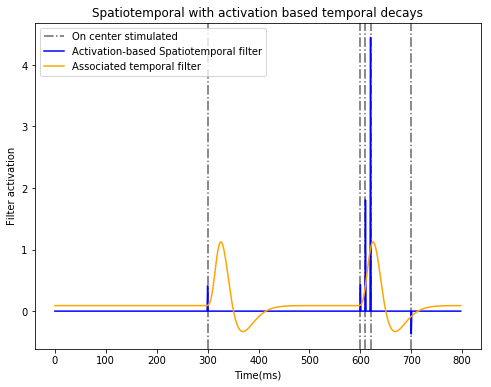

In [5]:
############
# Constants
############
baseline = 0.001
total_time = 800

########
# STIM
########
jap_flags = []
for i in range(total_time+1):
        xx, yy = np.mgrid[:100, :100]
        circle = (xx - 50) ** 2 + (yy - 50) ** 2
        japanese_flag = (circle > (7000))
        jap_flags.append(japanese_flag)
        
for i in [300, 600, 610, 620, 700]:
    xx, yy = np.mgrid[:100, :100]
    circle = (xx - 50) ** 2 + (yy - 50) ** 2
    japanese_flag = (circle < (500))
    jap_flags[i] =japanese_flag

###########
# Filters 
###########
X,Y,Z = spatial_filter()   
temporal = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]
activation_temporal = activation_temporal_filter(X=X,Y=Y,Z=Z, baseline=baseline,
                                             t = temporal, filtertime = total_time,
                                             activation_threshold = .001, refractory_period = 225,
                                             stim = jap_flags, stimtime = total_time)
new_st = spatiotemporal_filter(spatio_X = X, spatio_Y = Y, spatio_Z = Z,
                                   tempo = activation_temporal)

############
# Activation
############
jap_resp= []
for i, st_response_new in enumerate(new_st):
    jap_resp.append(np.sum(st_response_new * jap_flags[int(i)]))

####
# Plot the two filters
####
plt.figure(figsize = (8,6))
for i in [300, 600, 610, 620, 700]:
    plt.axvline(i, color = 'k', linestyle = '-.', label = 'On center stimulated' if i == 300 else '',
               alpha = .6)
plt.plot(jap_resp, label = 'Activation-based Spatiotemporal filter', color = 'b')
plt.plot(activation_temporal, label = 'Associated temporal filter', color = 'orange')
plt.xlabel('Time(ms)')
plt.ylabel('Filter activation')
plt.legend()
plt.title('Spatiotemporal with activation based temporal decays')
plt.savefig('./figs/2018_10_15_Activation_based_ST_response.pdf', format = 'pdf', dpi = 200,bbox_inches = 'tight' )
plt.show()

# Pour faire un bonne analyse, il faut un bon paradigme, donc on va utiliser un japanese flag bougeant

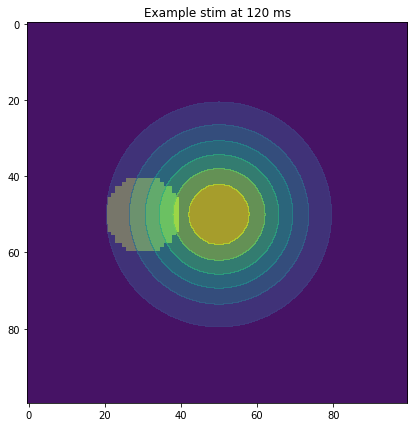

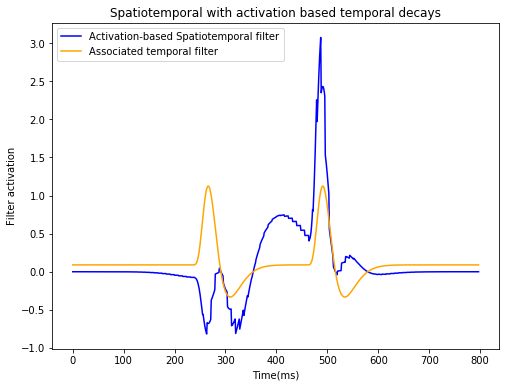

In [6]:
#A stim that moves from left to right now
jap_flags = []
for i in range(total_time+1):
        xx, yy = np.mgrid[:100, :100]
        circle = (xx - 50) ** 2 + (yy - int(i/8)) ** 2
        japanese_flag = (circle < 100)
        jap_flags.append(japanese_flag)

X,Y,Z = spatial_filter()   
temporal = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]
activation_temporal = activation_temporal_filter(X=X,Y=Y,Z=Z, baseline=baseline,
                                             t = temporal, filtertime = total_time,
                                             activation_threshold = .001, refractory_period = 225,
                                             stim = jap_flags, stimtime = total_time)
new_st = spatiotemporal_filter(spatio_X = X, spatio_Y = Y, spatio_Z = Z,
                                   tempo = activation_temporal)

plt.figure(figsize = (7,7))
plt.contourf((X+2)*25,(Y+2)*25,(Z+2)*25, alpha = .7)
plt.imshow(jap_flags[240])
plt.title('Example stim at 120 ms')

plt.pause(.1)

jap_resp= []
for i, st_response_new in enumerate(new_st):
    jap_resp.append(np.sum(st_response_new * jap_flags[int(i)]))

plt.figure(figsize = (8,6))
plt.plot(jap_resp, label = 'Activation-based Spatiotemporal filter', color = 'b')
plt.plot(activation_temporal, label = 'Associated temporal filter', color = 'orange')
plt.xlabel('Time(ms)')
plt.ylabel('Filter activation')
plt.legend()
plt.title('Spatiotemporal with activation based temporal decays')
plt.savefig('./figs/2018_10_15_Activation_based_MOVING_ST_response.pdf', format = 'pdf', dpi = 200,bbox_inches = 'tight' )

# Ensuite j'utilise la méthode de Dayan - Abbott (2001, livre, pg 32), pour génerer des spikes à partir d'un firing rate et de poisson
L'algo de base, c'est que pour un firing rate constant, on peut estimer les spike a partir d'une loi de poisson en choississant un nombre aléatoire à chaque étape de temps et en l'utilisant comme un threshold.
Pour un firing rate variable, on utilise ce qu'ils appellent le thnning, qui pour une limite calcule a partir d'une loi exponentielle la probabilité de spike

En terme mieux algorithmisées :
soit r_estimation le firing rate estimé, un temps total T et un pas delta_T, à chaque moment delta_T de T, une spike est émise ssi r_estimation > r_estimation * delta_T-1 - ln(un nombre random entre 0 et 1). Ensuite on divise le tout par une upper limite R_max :

In [7]:
trials = 10
meta_list = []
for t in range(trials) :
    r_max = np.max(jap_resp)
    
    #pourquoi exponential ? pourquoi pas ? c'est parce que c'est positif de partout ?
    explaw = np.random.exponential(20/ r_max, size = len(jap_resp))
    spike_times = np.cumsum(explaw)
    jap_resp = np.asarray(jap_resp)
    
    #evite les embarassants out of range
    remove_end = spike_times < 795
    remove_beg = spike_times > 10
    spike_times = spike_times[remove_end*remove_beg]

    spike_indexes = np.floor(spike_times).astype(int)
    x = np.random.rand(spike_indexes.size)

    ratio = jap_resp[spike_indexes]/r_max
    spike_times = spike_times[ratio >= x]
    meta_list.append(spike_times)

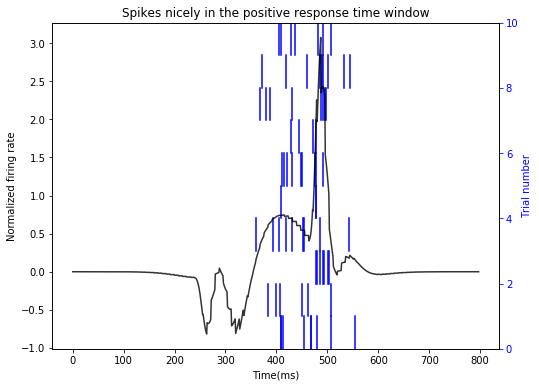

In [8]:
fig, ax = plt.subplots(figsize = (8,6))

for t in range(trials) :
    for spike in meta_list[t] :
        ax.axvline(spike, ymin = t/10, ymax = (t+1)/10, color = 'b',
                  label = 'Spikes' if t == 0 and spike <300 else '')

ax.plot(jap_resp, label = 'Activation-based Spatiotemporal filter', color = 'k', alpha = .8)
        

ax.tick_params(colors = 'k')
ax.set_ylabel('Normalized firing rate', color = 'k')
ax.set_xlabel('Time(ms)')

ax2 = ax.twinx()
ax2.tick_params(colors = 'b')
ax2.set_ylabel('Trial number', color = 'b')
ax2.set_yticklabels([0,2,4,6,8,10])

plt.title('Spikes nicely in the positive response time window')
plt.show()

# Et maintenant la fonction pour convertir un filtre spatiotemporel activé en spikes

In [9]:
def filter_to_spikes(activated_filter, exponential_size, random_seed):
    '''
    Converts an activated spatiotemporal filter (that is, convolved around a stimuli) into a series of 
    spike trains using Dayan-Abbott (2001) thinning
    Args :
    --> activated_filter = a spatiotemporal filter convolved around a stimuli
    --> exponential_size = the beta of the exponential distribution. Since we normalize it by the maximum
    activation of the filter's rate, the lower it is the more spike the conversion will produce (20 is nice)
    --> random_seed = fixes numpy's seed for reproducibility
    '''
    
    #activated_filter = np.asarray(activated_filter)
    np.random.seed(random_seed)
    r_max = np.max(activated_filter)

    explaw = np.random.exponential(exponential_size/ r_max, size = len(activated_filter))
    spike_times = np.cumsum(explaw)
    

    remove_end = spike_times < 795
    remove_beg = spike_times > 10
    spike_times = spike_times[remove_end*remove_beg]

    spike_indexes = np.floor(spike_times).astype(int)
    x = np.random.rand(spike_indexes.size)

    ratio = jap_resp[spike_indexes]/r_max
    spike_times = spike_times[ratio >= x]
    
    return spike_times

spiketimes = filter_to_spikes(jap_resp, 20, random_seed = 42)

# Finale :  maintenant de A à Z

In [15]:
############
# Constants
############
baseline = 0.001
total_time = 800

########
# STIM
########
jap_flags = []
for i in range(total_time+1):
        xx, yy = np.mgrid[:100, :100]
        circle = (xx - 50) ** 2 + (yy - int(i/8)) ** 2
        japanese_flag = (circle < 100)
        jap_flags.append(japanese_flag)

###########
# Filters 
###########
X,Y,Z = spatial_filter()   
temporal = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]
activation_temporal = activation_temporal_filter(X=X,Y=Y,Z=Z, baseline=baseline,
                                             t = temporal, filtertime = total_time,
                                             activation_threshold = .001, refractory_period = 225,
                                             stim = jap_flags, stimtime = total_time)
st_filter = spatiotemporal_filter(spatio_X = X, spatio_Y = Y, spatio_Z = Z,
                                   tempo = activation_temporal)

############
# Activation
############
st_activations= []
for i, st_response_new in enumerate(st_filter):
    st_activations.append(np.sum(st_response_new * jap_flags[int(i)]))
    
############
# Conversion
############
spiketimes = filter_to_spikes(st_activations, 20, random_seed = 42)

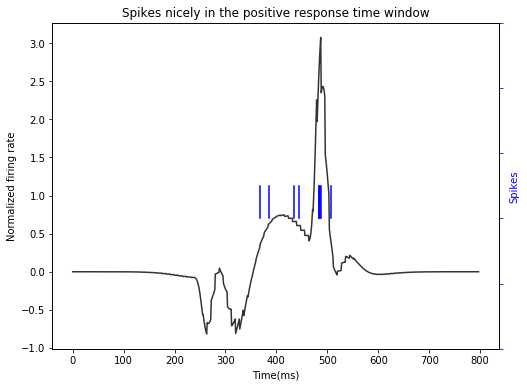

In [19]:
fig, ax = plt.subplots(figsize = (8,6))

for i, spike in enumerate(spiketimes) :
    ax.axvline(spike, ymin = .4, ymax = .5, color = 'b',
              label = 'Spikes' if t == 0 and spike <300 else '')

ax.plot(st_activations, label = 'Activation-based Spatiotemporal filter', color = 'k', alpha = .8)
        

ax.tick_params(colors = 'k')
ax.set_ylabel('Normalized firing rate', color = 'k')
ax.set_xlabel('Time(ms)')

ax2 = ax.twinx()
ax2.tick_params(colors = 'b')
ax2.set_ylabel('Spikes', color = 'b')
ax2.set_yticklabels([])

plt.title('Spikes nicely in the positive response time window')
plt.show()

# Animation du rond qui bouge

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn

%matplotlib notebook
fig = plt.figure()

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(800):
    xx, yy = np.mgrid[:100, :100]
    circle = (xx - 50) ** 2 + (yy - int(i/8)) ** 2
    japanese_flag = (circle < 500)
    im = plt.imshow(japanese_flag, animated=True, cmap = plt.cm.binary)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval = 10,
                                 repeat = True)
plt.show()

% matplotlib notebook

# Ca c'est super expérimental et ça a sérieusement de quoi faire fondre le CPU, a toucher avec prudence !
from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

fig = plt.figure()
ax = p3.Axes3D(fig)

maxtime = 224
X,Y,Z = spatial_filter()
ys = [temporal_filter(i) for i in np.linspace(0,maxtime,maxtime)]

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(maxtime):
    im = ax.plot_surface(X,Y, ys[i]*Z, cmap = plt.cm.viridis, vmin = -.02, vmax = .05,)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval = 10,
                                 repeat = True, blit = False)
ani.save('matplot002.gif', writer='imagemagick', dpi = 200)
plt.show()